# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc, RocCurveDisplay
from scipy.stats import ttest_rel, ttest_1samp, iqr
import pickle

import warnings
warnings.filterwarnings("ignore", category = UserWarning)

# Preprocessing

In [2]:
# Preprocess dataset (Outputs: ids, trial_nums, predictors_df, outcomes_df, outcomes_df_shuffled)
# Import dataset
df = pd.read_csv("./../Datasets/kieranFeatures_1-31_21-Jan-2025_avgof3_rawSA.csv").replace([np.inf, -np.inf], np.nan)

# Create Low vs High Columns
df["Lv_1_Lo"] = (df["SA1"] < 5).astype(np.bool_)
df["Lv_2_Lo"] = (df["SA2"] < 5).astype(np.bool_)
df["Lv_3_Lo"] = (df["SA3"] < 5).astype(np.bool_)
df["Tot_Lo"] = (df["SAtotal"] < 15).astype(np.bool_)

# Impute missing values with mean of column
for col in df.columns:
    df[col] = df[col].fillna(value = df[col].mean())

# Split up dataset
ids = df["ID"].astype(np.uint8)
predictors_df = df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal", "Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]).astype(np.float64)
outcomes_df = df[["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo", "SA1", "SA2", "SA3", "SAtotal"]]
outcomes_df_shuffled = outcomes_df.copy()

# Shuffle labels for shuffled data
outcomes_df_shuffled["Lv_1_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_1_Lo"])
outcomes_df_shuffled["Lv_2_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_2_Lo"])
outcomes_df_shuffled["Lv_3_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_3_Lo"])
outcomes_df_shuffled["Tot_Lo"] = np.random.permutation(outcomes_df_shuffled["Tot_Lo"])

# Divide up dataframe
ids = df["ID"]
ECG_df = df.loc[:, [col for col in df if col.startswith("ECG")]]
EDA_df = df.loc[:, [col for col in df if col.startswith("EDA")]]
EEG_df = df.loc[:, [col for col in df if col.startswith("EEG")]]
EYE_df = df.loc[:, [col for col in df if col.startswith("EYE")]]
fNIRS_df = df.loc[:, [col for col in df if col.startswith("fNIRS")]]
RSP_df = df.loc[:, [col for col in df if col.startswith("RSP")]]
sensor_dfs = [(ECG_df, "ECG"), (EDA_df, "EDA"), (EEG_df, "EEG"), (EYE_df, "EYE"), (fNIRS_df, "fNIRS"), (RSP_df, "RSP")]

# Free up memory
del col, df, predictors_df

# Class Distributions

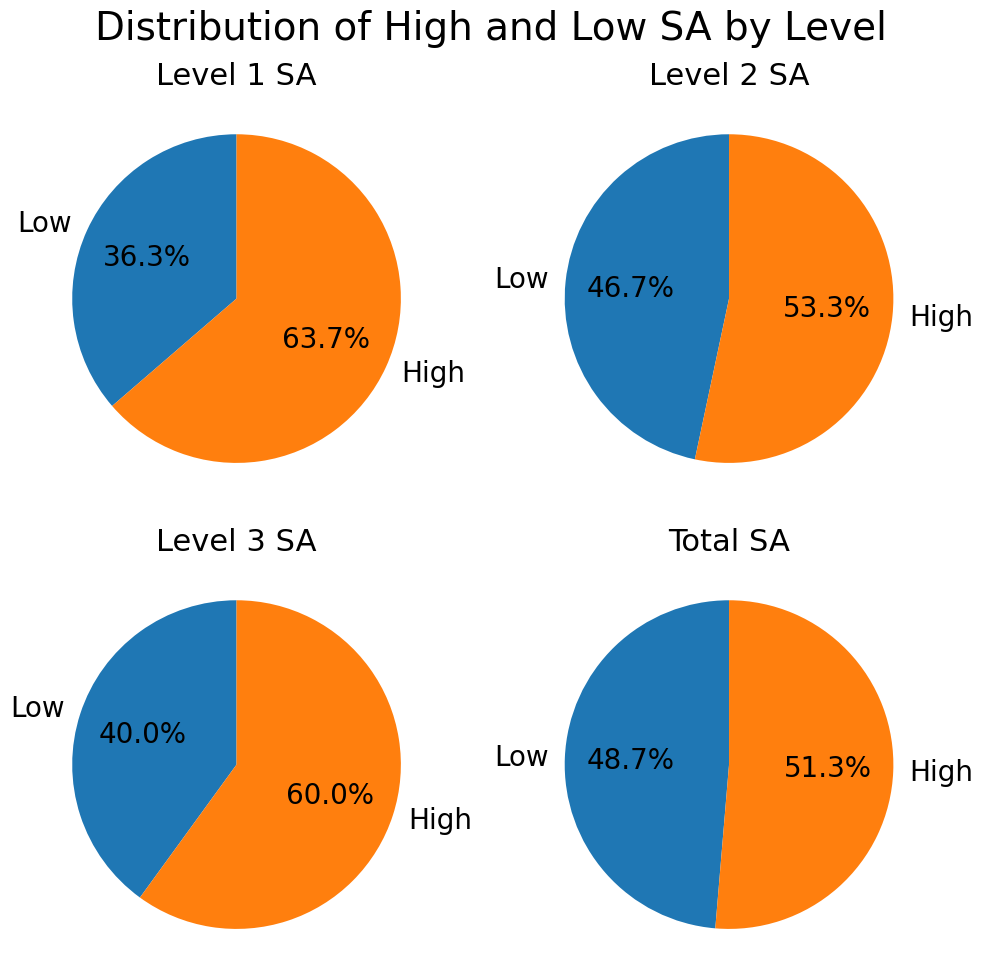

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (10, 10))
labels = ["Low", "High"]
colors = ["C0", "C1"]

ax1[0].set_title("Level 1 SA", fontsize = 22)
ax1[0].pie([np.sum(outcomes_df["Lv_1_Lo"]), np.sum(~outcomes_df["Lv_1_Lo"])], labels = labels, colors = colors, autopct = "%1.1f%%", startangle = 90, textprops = {"fontsize": 20})

ax1[1].set_title("Level 2 SA", fontsize = 22)
ax1[1].pie([np.sum(outcomes_df["Lv_2_Lo"]), np.sum(~outcomes_df["Lv_2_Lo"])], labels = labels, colors = colors, autopct = "%1.1f%%", startangle = 90, textprops = {"fontsize": 20})

ax2[0].set_title("Level 3 SA", fontsize = 22)
ax2[0].pie([np.sum(outcomes_df["Lv_3_Lo"]), np.sum(~outcomes_df["Lv_3_Lo"])], labels = labels, colors = colors, autopct = "%1.1f%%", startangle = 90, textprops = {"fontsize": 20})

ax2[1].set_title("Total SA", fontsize = 22)
ax2[1].pie([np.sum(outcomes_df["Tot_Lo"]), np.sum(~outcomes_df["Tot_Lo"])], labels = labels, colors = colors, autopct = "%1.1f%%", startangle = 90, textprops = {"fontsize": 20})

fig.suptitle("Distribution of High and Low SA by Level", fontsize = 28)
fig.tight_layout()
plt.savefig("./../Images/Paper Figures/Average_Of_3_SA_Distributions.svg")

# F1 and Accuracy Scores

In [4]:
# Load data
with open("./../Pickle Files/Weighted_Average_Scores.pkl", "rb") as f:
    f1_scores, accuracy_scores = pickle.load(f)

del f

In [5]:
def graph_actual_vs_shuffled(scores, metric):
    # Initialize scores data for plotting
    actual_scores = [scores["Actual"][level] for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]]
    shuffled_scores = [scores["Shuffled"][level] for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]]

    # Positions for main categories on x-axis
    x_base_positions = np.arange(1, len(actual_scores) + 1) # [1, 2, 3, 4]

    # Width of each individual boxplot
    box_width = 0.4

    # Calculate positions for actual and shuffled boxplots
    # Actual boxplots on left and shuffled on right
    positions_actual = x_base_positions - box_width / 2
    positions_shuffled = x_base_positions + box_width / 2

    # Define colors
    color_actual = "lightblue"
    color_shuffled = "lightcoral"

    # Plot Actual vs Shuffled
    fig = plt.figure(figsize = (3.5, 3))
    plt.boxplot(actual_scores,
                vert = True,
                positions = positions_actual,
                widths = box_width,
                label = "Actual",
                patch_artist = True,
                boxprops = dict(facecolor = color_actual, color = "black"),
                whiskerprops = dict(color = "black"),
                capprops = dict(color = "black"),
                medianprops = dict(color = "black"))
    plt.boxplot(shuffled_scores,
                vert = True,
                positions = positions_shuffled,
                widths = box_width,
                label = "Shuffled",
                patch_artist = True,
                boxprops = dict(facecolor = color_shuffled, color = "black"),
                whiskerprops = dict(color = "black"),
                capprops = dict(color = "black"),
                medianprops = dict(color = "black"))
    # Datapoints
    for i, (actual_score, shuffled_score) in enumerate(zip(actual_scores, shuffled_scores)):
        jitter = np.random.normal(-0.03, 0.03, size = len(actual_score))
        plt.plot([positions_actual[i] + jitter, positions_shuffled[i] + jitter], [actual_score, shuffled_score], linewidth = 0.75, color = "gray", alpha = 0.5)

    # Plot baselines
    score_baselines, always_true_baselines, always_false_baselines = get_baselines(metric)
    xmin_baselines = positions_actual - box_width / 2
    xmax_baselines = positions_shuffled + box_width / 2
    plt.hlines(score_baselines, xmin_baselines, xmax_baselines, color = "darkgreen", linestyle = "--", label = f"RG")
    if metric == "F1":
        plt.hlines(always_true_baselines, xmin_baselines, xmax_baselines, color = "r", linestyle = "--", label = "Always True")
    else:
        plt.hlines(always_false_baselines, xmin_baselines, xmax_baselines, color = "b", linestyle = "--", label = "Always False")

    # Labels
    level_labels = ["Level 1", "Level 2", "Level 3", "Total"]

    # Customize axes
    plt.ylabel(f"{metric} Score", fontsize = 9)
    plt.ylim(0, 1)
    plt.yticks(fontsize = 8)
    plt.xlabel("SA Level", fontsize = 9)
    plt.xticks(x_base_positions, level_labels, fontsize = 8)

    if metric == "F1":
        plt.legend(
            loc = "upper right",
            bbox_to_anchor = (1.017, 1.015),
            fontsize = 7,
            ncol = 4,
            columnspacing = 0.5)
    else:
        plt.legend(
            loc = "upper right",
            bbox_to_anchor = (1.025, 1.015),
            fontsize = 7,
            ncol = 4,
            columnspacing = 0.4)
    plt.tight_layout()
    plt.savefig(f"./../Images/Paper Figures/Actual_vs_Shuffled_{metric}_Scores.svg", bbox_inches = "tight", pad_inches = 0)

def get_baselines(metric):
    # Initialize empty lists to store baseline values
    score_baselines = []
    always_true_baselines = []
    always_false_baselines = []

    for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
        # Initialize empty lists to store baseline values for `level`
        score_baseline_values = []
        always_true_baseline_values = []
        always_false_baseline_values = []

        # Get baselines for each fold
        skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
        for _, (_, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            # Train-Test Split for the Fold
            out_test = outcomes_df.iloc[test_idx]

            if metric == "F1":
                score_baseline_values.append((np.mean(out_test[level])) / (np.mean(out_test[level]) + 0.5))
                always_true_baseline_values.append(f1_score(out_test[level], np.array([1 for _ in range(len(out_test[level]))])))
            elif metric == "Accuracy":
                score_baseline_values.append(0.5)
                always_false_baseline_values.append(accuracy_score(outcomes_df[level], np.array([0 for _ in range(len(outcomes_df[level]))])))
        
        # Append the baseline values for the current level
        score_baselines.append(np.mean(score_baseline_values))
        if metric == "F1":
            always_true_baselines.append(np.mean(always_true_baseline_values))
        else:
            always_false_baselines.append(np.mean(always_false_baseline_values))        

    return score_baselines, always_true_baselines, always_false_baselines

## F1 Scores

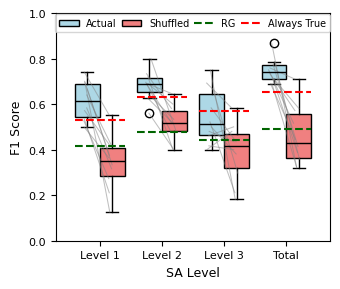

In [6]:
graph_actual_vs_shuffled(f1_scores, "F1")

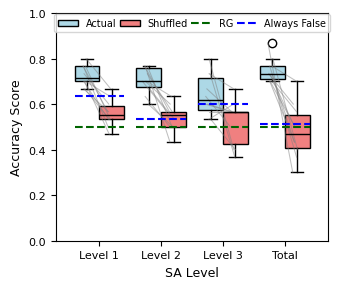

In [7]:
graph_actual_vs_shuffled(accuracy_scores, "Accuracy")

## Mean, Median, IQR Of F1 and Accuracy Across All Iterations

In [8]:
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    print(level)
    print(f"F1: {np.mean(f1_scores['Actual'][level]):.2f}")
    print(f"Accuracy: {np.mean(accuracy_scores['Actual'][level]):.2f}")
    print()

Lv_1_Lo
F1: 0.62
Accuracy: 0.73

Lv_2_Lo
F1: 0.68
Accuracy: 0.70

Lv_3_Lo
F1: 0.55
Accuracy: 0.64

Tot_Lo
F1: 0.75
Accuracy: 0.75



In [9]:
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    print(level)
    print(f"F1: {np.median(f1_scores['Actual'][level]):.2f}")
    print(f"Accuracy: {np.median(accuracy_scores['Actual'][level]):.2f}")
    print()

Lv_1_Lo
F1: 0.61
Accuracy: 0.72

Lv_2_Lo
F1: 0.69
Accuracy: 0.70

Lv_3_Lo
F1: 0.51
Accuracy: 0.62

Tot_Lo
F1: 0.74
Accuracy: 0.73



In [10]:
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    print(level)
    print(f"F1: {iqr(f1_scores['Actual'][level]):.2f}")
    print(f"Accuracy: {iqr(accuracy_scores['Actual'][level]):.2f}")
    print()

Lv_1_Lo
F1: 0.15
Accuracy: 0.07

Lv_2_Lo
F1: 0.06
Accuracy: 0.08

Lv_3_Lo
F1: 0.18
Accuracy: 0.14

Tot_Lo
F1: 0.06
Accuracy: 0.06



## T-Tests

In [11]:
def actual_vs_shuffled_t_test(model_scores, lvl):
    print(f'{"t" : <7}{"p" : <7}')
    t_stat, p_val = ttest_rel(
        model_scores["Actual"][lvl],
        model_scores["Shuffled"][lvl]
    )
    print(f'{t_stat : <7.3f}{p_val : >5.4f}')
    print()

def one_sample_t_test(model_scores, baseline_score, lvl):
    print(f'{"t" : <7}{"p" : <7}')
    t_stat, p_val = ttest_1samp(
        a = model_scores["Actual"][lvl], 
        popmean = np.mean(baseline_score))
    print(f'{t_stat : <7.3f}{p_val : >5.4f}')
    print()

def get_baselines(outcomes_df, lvl, ids):
    baseline_f1_scores = []
    baseline_f1_always_true_scores = []
    baseline_accuracy_score = 0.5
    baseline_accuracy_always_false_scores = []

    # Gather Baselines for Each Fold
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    for i, (_, test_idx) in enumerate(skf.split(outcomes_df, ids)):
        out_test = outcomes_df.loc[test_idx, lvl].values

        # Calculate F1 Baseline
        precision = np.mean(out_test)
        recall = 0.5
        baseline_f1_scores.append(np.mean((2 * precision * recall) / (precision + recall)))

        # Calculate F1 Always True Baseline
        baseline_f1_always_true_scores.append(f1_score(out_test, np.array([1 for _ in range(len(out_test))])))

        # Calculate Accuracy Always False Baseline
        baseline_accuracy_always_false_scores.append(accuracy_score(out_test, np.array([0 for _ in range(len(out_test))])))

    return (np.mean(baseline_f1_scores), np.mean(baseline_f1_always_true_scores), baseline_accuracy_score, np.mean(baseline_accuracy_always_false_scores))

### F1

In [12]:
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    print(f"Actual vs Shuffled T-Test for {level}")
    actual_vs_shuffled_t_test(f1_scores, level)
    print()

    # Get Baselines for F1
    f1_baseline, f1_always_true_baseline, _, _ = get_baselines(outcomes_df, level, ids)

    print("vs F1 Baseline")
    one_sample_t_test(f1_scores, f1_baseline, level)
    print()

    print("vs F1 Always True Baseline")
    one_sample_t_test(f1_scores, f1_always_true_baseline, level)
    print()

Actual vs Shuffled T-Test for Lv_1_Lo
t      p      
7.006  0.0001


vs F1 Baseline
t      p      
7.509  0.0000


vs F1 Always True Baseline
t      p      
3.283  0.0095


Actual vs Shuffled T-Test for Lv_2_Lo
t      p      
5.820  0.0003


vs F1 Baseline
t      p      
10.074 0.0000


vs F1 Always True Baseline
t      p      
2.628  0.0274


Actual vs Shuffled T-Test for Lv_3_Lo
t      p      
2.452  0.0366


vs F1 Baseline
t      p      
2.724  0.0235


vs F1 Always True Baseline
t      p      
-0.600 0.5632


Actual vs Shuffled T-Test for Tot_Lo
t      p      
6.017  0.0002


vs F1 Baseline
t      p      
15.005 0.0000


vs F1 Always True Baseline
t      p      
5.499  0.0004




### Accuracy

In [13]:
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    print(f"Actual vs Shuffled T-Test for {level}")
    actual_vs_shuffled_t_test(f1_scores, level)
    print()

    # Get Baselines for Accuracy
    _, _, accuracy_baseline, accuracy_always_false_baseline = get_baselines(outcomes_df, level, ids)

    print("vs Accuracy Baseline")
    one_sample_t_test(accuracy_scores, accuracy_baseline, level)
    print()

    print("vs Accuracy Always False Baseline")
    one_sample_t_test(accuracy_scores, accuracy_always_false_baseline, level)
    print()

Actual vs Shuffled T-Test for Lv_1_Lo
t      p      
7.006  0.0001


vs Accuracy Baseline
t      p      
15.377 0.0000


vs Accuracy Always False Baseline
t      p      
6.106  0.0002


Actual vs Shuffled T-Test for Lv_2_Lo
t      p      
5.820  0.0003


vs Accuracy Baseline
t      p      
11.158 0.0000


vs Accuracy Always False Baseline
t      p      
9.329  0.0000


Actual vs Shuffled T-Test for Lv_3_Lo
t      p      
2.452  0.0366


vs Accuracy Baseline
t      p      
4.846  0.0009


vs Accuracy Always False Baseline
t      p      
1.385  0.1995


Actual vs Shuffled T-Test for Tot_Lo
t      p      
6.017  0.0002


vs Accuracy Baseline
t      p      
15.000 0.0000


vs Accuracy Always False Baseline
t      p      
14.200 0.0000




# Sensor Importance (F1 Weights)

In [3]:
# Load data
with open("./../Pickle Files/3_Moving_Average_Model_by_Sensor_With_Intercepts.pkl", "rb") as f:
    f1_scores, accuracy_scores, models = pickle.load(f)

## Pie Chart

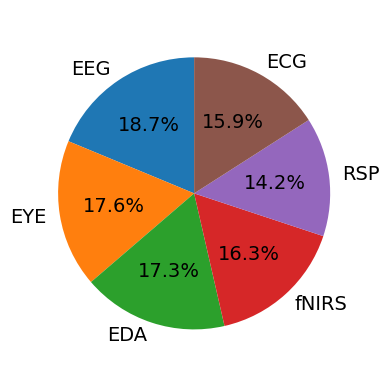

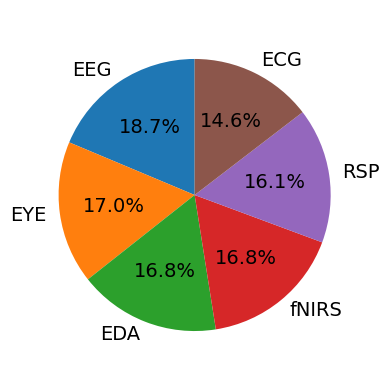

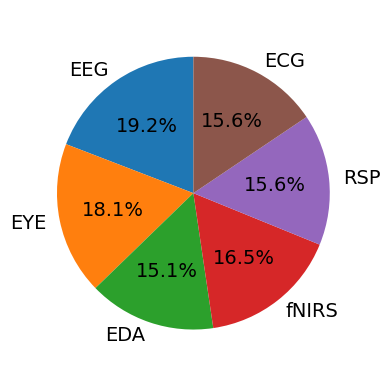

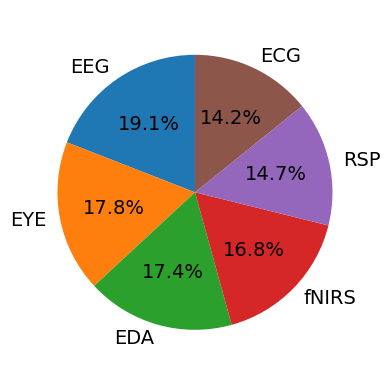

In [10]:
levels = ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]
mean_importances = {}

# Compute mean importance values for all levels
for level in levels:
    # Mean F1 for each sensor
    mean_scores = {
        sensor: np.mean(f1_scores["Actual"][level][sensor])
        for sensor in f1_scores["Actual"][level]
    }

    # Normalize scores to convert to importance values
    total = sum(mean_scores.values())
    mean_importances[level] = { sensor: value / total for sensor, value in mean_scores.items() }

# Choose consistent sensor ordering using Tot_Lo as reference
reference = mean_importances["Tot_Lo"]
sensor_order = sorted(reference, key = lambda s: reference[s], reverse = True)

# Choose consistent sensor color using tab10 palette
palette = plt.get_cmap("tab10")
color_map = { sensor: palette(i) for i, sensor in enumerate(sensor_order) }

# Plot one pie chart per level
for level in levels:
    values = [mean_importances[level][s] for s in sensor_order]
    
    fig, ax = plt.subplots(figsize = (4, 4))
    wedges, texts, autotexts = ax.pie(
        values,
        labels = sensor_order,
        colors = [color_map[s] for s in sensor_order],
        autopct = "%1.1f%%",
        startangle = 90,
        textprops = {"fontsize": 14}
    )
    ax.axis("equal")  # keep circle
    
    # Save and show
    plt.tight_layout()
    plt.savefig(f"./../Images/Paper Figures/{level}_Sensor_Importance.svg", bbox_inches = "tight", pad_inches = 0)
    plt.show()

## Bar Graph

Mean Importance for Lv_1_Lo


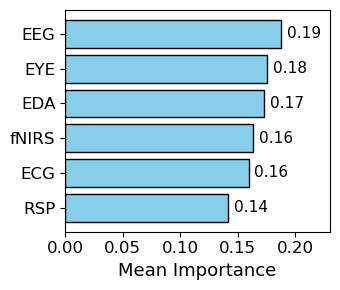

Mean Importance for Lv_2_Lo


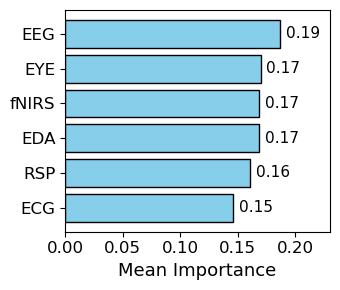

Mean Importance for Lv_3_Lo


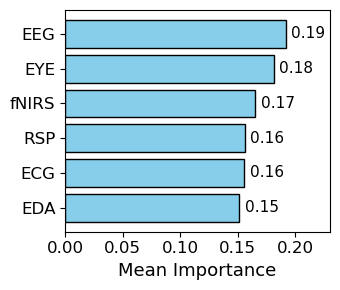

Mean Importance for Tot_Lo


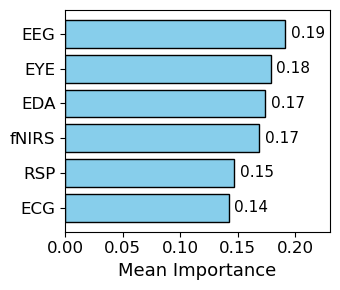

In [15]:
# Importance determined by mean performance on test set
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    print("Mean Importance for", level)

    mean_f1_scores = {sensor: np.mean(f1_scores["Actual"][level][sensor]) for sensor in f1_scores["Actual"][level].keys()}
    total_mean_f1_score = np.sum(list(mean_f1_scores.values()))
    mean_f1_scores = {sensor: mean_f1_scores[sensor] / total_mean_f1_score for sensor in f1_scores["Actual"][level].keys()}

    # Sort weights in ascending order to present in descending order
    sorted_importances = sorted(mean_f1_scores.items(), key = lambda x: x[1])
    sensors, importances = zip(*sorted_importances)

    # Graph mean weights
    fig = plt.figure(figsize = (3.5, 3))
    y_pos = np.arange(len(sensors))
    base_fontsize = 12

    plt.barh(y_pos, importances, color = "skyblue", edgecolor = "k")
    plt.yticks(y_pos, sensors, fontsize = base_fontsize)
    plt.xticks(fontsize = base_fontsize)
    plt.xlabel("Mean Importance", fontsize = base_fontsize + 1)
    plt.xlim([0, 0.23])

    # Annotate bar values
    for i, v in enumerate(importances):
        plt.text(v + 0.005, i, f"{v:.2f}", va = "center", fontsize = base_fontsize - 1)

    plt.tight_layout()
    plt.savefig(f"./../Images/Paper Figures/{level}_Sensor_Weights.svg", bbox_inches = "tight", pad_inches = 0)
    plt.show()

## Sensor Ranking by Fold

In [11]:
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    print("Importances for", level)

    # Data structure to hold sensor ranks and scores
    sensor_ranks = {i: [] for i in range(1, 7)}
    sensor_ranks_scores = {i: [] for i in range(1, 7)}

    for fold in range(10):
        sensor_f1_scores = {sensor: f1_scores["Actual"][level][sensor][fold] for sensor in f1_scores["Actual"][level].keys()}
        fold_total_f1_score = np.sum(list(sensor_f1_scores.values()))
        normalized_sensor_f1_scores = {sensor: np.round(sensor_f1_scores[sensor] / fold_total_f1_score, 3).item() for sensor in f1_scores["Actual"][level].keys()}
    
        # Importance determined by performance on test set
        sorted_importances = sorted(normalized_sensor_f1_scores.items(), key = lambda x: x[1], reverse = True)
        sensor_ranks[fold] = sorted_importances

    # Convert to dataframe for easier viewing
    sensor_ranks_df = pd.DataFrame(sensor_ranks)
    display(sensor_ranks_df)

    # # Graph mean weights
    # fig = plt.figure(figsize = (3.5, 3))
    # y_pos = np.arange(len(sensors))
    # base_fontsize = 12

    # plt.barh(y_pos, importances, color = "skyblue", edgecolor = "k")
    # plt.yticks(y_pos, sensors, fontsize = base_fontsize)
    # plt.xticks(fontsize = base_fontsize)
    # plt.xlabel("Mean Importance", fontsize = base_fontsize + 1)
    # plt.xlim([0, 0.23])

    # # Annotate bar values
    # for i, v in enumerate(importances):
    #     plt.text(v + 0.005, i, f"{v:.2f}", va = "center", fontsize = base_fontsize - 1)

    # plt.tight_layout()
    # plt.savefig(f"./../Images/Paper Figures/{level}_Sensor_Weights.svg", bbox_inches = "tight", pad_inches = 0)
    # plt.show()

Importances for Lv_1_Lo


,1,2,3,4,5,6,0,7,8,9
0,"(EYE, 0.193)","(RSP, 0.226)","(EEG, 0.211)","(fNIRS, 0.208)","(EEG, 0.205)","(EDA, 0.237)","(EYE, 0.205)","(EDA, 0.216)","(ECG, 0.208)","(EYE, 0.201)"
1,"(EDA, 0.173)","(fNIRS, 0.201)","(EDA, 0.192)","(EYE, 0.176)","(EYE, 0.196)","(ECG, 0.224)","(fNIRS, 0.188)","(EEG, 0.207)","(EDA, 0.186)","(EEG, 0.198)"
2,"(ECG, 0.167)","(EEG, 0.185)","(EYE, 0.192)","(RSP, 0.176)","(ECG, 0.18)","(EEG, 0.192)","(EEG, 0.182)","(EYE, 0.181)","(fNIRS, 0.17)","(EDA, 0.172)"
3,"(EEG, 0.167)","(EYE, 0.143)","(RSP, 0.158)","(EEG, 0.167)","(EDA, 0.145)","(EYE, 0.134)","(EDA, 0.169)","(fNIRS, 0.148)","(EEG, 0.163)","(ECG, 0.165)"
4,"(fNIRS, 0.167)","(ECG, 0.131)","(fNIRS, 0.126)","(EDA, 0.143)","(fNIRS, 0.14)","(fNIRS, 0.107)","(ECG, 0.165)","(RSP, 0.135)","(RSP, 0.151)","(fNIRS, 0.158)"
5,"(RSP, 0.131)","(EDA, 0.115)","(ECG, 0.12)","(ECG, 0.132)","(RSP, 0.134)","(RSP, 0.105)","(RSP, 0.091)","(ECG, 0.113)","(EYE, 0.121)","(RSP, 0.106)"


Importances for Lv_2_Lo


,1,2,3,4,5,6,0,7,8,9
0,"(EEG, 0.204)","(fNIRS, 0.199)","(EEG, 0.223)","(fNIRS, 0.19)","(fNIRS, 0.204)","(EEG, 0.205)","(RSP, 0.189)","(EYE, 0.194)","(EEG, 0.192)","(EEG, 0.227)"
1,"(EYE, 0.183)","(EDA, 0.177)","(EDA, 0.172)","(EDA, 0.181)","(EDA, 0.191)","(EYE, 0.173)","(EEG, 0.184)","(EDA, 0.188)","(EYE, 0.171)","(fNIRS, 0.175)"
2,"(EDA, 0.169)","(EEG, 0.17)","(EYE, 0.171)","(RSP, 0.175)","(EYE, 0.179)","(RSP, 0.173)","(fNIRS, 0.172)","(RSP, 0.188)","(ECG, 0.167)","(EYE, 0.172)"
3,"(fNIRS, 0.159)","(EYE, 0.157)","(RSP, 0.155)","(ECG, 0.155)","(EEG, 0.171)","(fNIRS, 0.166)","(EDA, 0.166)","(EEG, 0.152)","(RSP, 0.162)","(ECG, 0.146)"
4,"(ECG, 0.153)","(ECG, 0.149)","(ECG, 0.147)","(EEG, 0.15)","(RSP, 0.142)","(ECG, 0.144)","(EYE, 0.153)","(ECG, 0.141)","(EDA, 0.157)","(EDA, 0.14)"
5,"(RSP, 0.131)","(RSP, 0.149)","(fNIRS, 0.131)","(EYE, 0.15)","(ECG, 0.113)","(EDA, 0.138)","(ECG, 0.137)","(fNIRS, 0.136)","(fNIRS, 0.152)","(RSP, 0.14)"


Importances for Lv_3_Lo


,1,2,3,4,5,6,0,7,8,9
0,"(EYE, 0.197)","(fNIRS, 0.202)","(EYE, 0.205)","(EEG, 0.206)","(EYE, 0.196)","(RSP, 0.217)","(EEG, 0.19)","(EDA, 0.215)","(EEG, 0.2)","(EEG, 0.252)"
1,"(fNIRS, 0.19)","(EDA, 0.199)","(EDA, 0.184)","(EYE, 0.199)","(EEG, 0.188)","(EEG, 0.182)","(ECG, 0.177)","(ECG, 0.172)","(fNIRS, 0.184)","(EYE, 0.225)"
2,"(RSP, 0.19)","(RSP, 0.177)","(EEG, 0.183)","(fNIRS, 0.197)","(ECG, 0.171)","(ECG, 0.165)","(EDA, 0.176)","(EEG, 0.169)","(EDA, 0.168)","(fNIRS, 0.184)"
3,"(EEG, 0.163)","(EEG, 0.172)","(ECG, 0.143)","(RSP, 0.174)","(EDA, 0.159)","(EYE, 0.165)","(EYE, 0.163)","(EYE, 0.169)","(EYE, 0.155)","(ECG, 0.17)"
4,"(ECG, 0.152)","(EYE, 0.128)","(fNIRS, 0.143)","(ECG, 0.14)","(fNIRS, 0.147)","(EDA, 0.158)","(fNIRS, 0.163)","(RSP, 0.148)","(RSP, 0.15)","(RSP, 0.115)"
5,"(EDA, 0.109)","(ECG, 0.123)","(RSP, 0.143)","(EDA, 0.084)","(RSP, 0.139)","(fNIRS, 0.114)","(RSP, 0.131)","(fNIRS, 0.128)","(ECG, 0.144)","(EDA, 0.055)"


Importances for Tot_Lo


,1,2,3,4,5,6,0,7,8,9
0,"(EYE, 0.187)","(EEG, 0.21)","(EEG, 0.195)","(RSP, 0.188)","(EYE, 0.231)","(EEG, 0.218)","(EYE, 0.205)","(EDA, 0.196)","(EEG, 0.179)","(EEG, 0.208)"
1,"(fNIRS, 0.182)","(fNIRS, 0.201)","(fNIRS, 0.182)","(EYE, 0.177)","(EDA, 0.184)","(EDA, 0.19)","(EEG, 0.188)","(EEG, 0.192)","(EDA, 0.174)","(EYE, 0.197)"
2,"(EDA, 0.17)","(ECG, 0.168)","(EDA, 0.171)","(EEG, 0.171)","(EEG, 0.184)","(fNIRS, 0.162)","(EDA, 0.182)","(EYE, 0.165)","(EYE, 0.174)","(EDA, 0.173)"
3,"(EEG, 0.17)","(RSP, 0.152)","(EYE, 0.159)","(fNIRS, 0.171)","(fNIRS, 0.16)","(EYE, 0.155)","(fNIRS, 0.153)","(fNIRS, 0.165)","(RSP, 0.168)","(ECG, 0.158)"
4,"(RSP, 0.164)","(EDA, 0.14)","(RSP, 0.149)","(EDA, 0.159)","(ECG, 0.12)","(ECG, 0.148)","(ECG, 0.146)","(RSP, 0.149)","(fNIRS, 0.158)","(fNIRS, 0.149)"
5,"(ECG, 0.127)","(EYE, 0.129)","(ECG, 0.144)","(ECG, 0.133)","(RSP, 0.12)","(RSP, 0.127)","(RSP, 0.127)","(ECG, 0.132)","(ECG, 0.148)","(RSP, 0.116)"


# ROC-AUC Curve

In [14]:
# Load data
with open("./../Pickle Files/3_Moving_Average_Model_by_Sensor_With_Intercepts.pkl", "rb") as f:
    f1_scores, accuracy_scores, models = pickle.load(f)

del f

## Get Prediction Probabilities

In [ ]:
# Initialize data storage
dataset_types = ["Actual", "Shuffled"]
levels = ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]

weighted_average_probability_prediction_probabiltiies = {}

for dataset in dataset_types:
    weighted_average_probability_prediction_probabiltiies[dataset] = {}

    for level in levels:
        weighted_average_probability_prediction_probabiltiies[dataset][level] = []

# Tally up and store weighted average predictions
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
sensor_dfs = [("ECG", ECG_df), ("EDA", EDA_df), ("EEG", EEG_df), ("EYE", EYE_df), ("fNIRS", fNIRS_df), ("RSP", RSP_df)]

# Keep track of test set ground truth values for ROC AUC curve calculation
out_tests = []

for dataset_type in dataset_types:
    for level in levels:
        for i, (train_idx, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            test_set_probas = {} # Store test probabilities per sensor for the fold
            f1_scores_by_sensor = {}
            total_f1_score = 0.0

            out_train = outcomes_df.loc[train_idx, level].values
            out_test = outcomes_df.loc[test_idx, level].values
            out_tests.append(out_test)

            for sensor, df in sensor_dfs:
                # Train-Test Split for the Fold
                pred_train = df.iloc[train_idx, :].values
                pred_test = df.iloc[test_idx, :]

                # Standardize Data
                scaler = StandardScaler()
                pred_train_normalized = scaler.fit_transform(pred_train)
                pred_test_normalized = scaler.transform(pred_test)

                # Get Metrics for the Training Set
                sensor_model = models[dataset_type][level][sensor][i]
                sensor_f1_score = f1_score(out_train, sensor_model.predict(pred_train_normalized))
                f1_scores_by_sensor[sensor] = sensor_f1_score

                total_f1_score += f1_scores_by_sensor[sensor]

                # Get Probability Predictions for Test Set
                test_set_probas[sensor] = sensor_model.predict_proba(pred_test_normalized)[:, 1]

            # Calculate Weighted Average After Processing All Sensors
            final_probas = np.zeros(len(test_idx), dtype = float)

            # Calculate the Weighted Average Probability Predictions
            for sensor, df in sensor_dfs:
                weight = f1_scores_by_sensor[sensor] / total_f1_score
                final_probas = np.add(final_probas, weight * test_set_probas[sensor])

            weighted_average_probability_prediction_probabiltiies[dataset_type][level].append(final_probas)

ECG 0.14698348225711927
EDA 0.17078425584428544
EEG 0.18117688736935866
EYE 0.14628356091303774
fNIRS 0.2194253413695566
RSP 0.13534647224664237
ECG 0.1535622100817536
EDA 0.17673336083887958
EEG 0.17822731842753875
EYE 0.15156789566510745
fNIRS 0.2183774286227535
RSP 0.12153178636396716
ECG 0.16114643775045626
EDA 0.19138211968542682
EEG 0.15873573154705473
EYE 0.15024521567360763
fNIRS 0.21826163087720024
RSP 0.12022886446625437
ECG 0.16204294814051773
EDA 0.17617772131287793
EEG 0.17025082411947595
EYE 0.142620060110425
fNIRS 0.21917347472852075
RSP 0.1297349715881827
ECG 0.14784617155935748
EDA 0.16397389462164721
EEG 0.1817008021483118
EYE 0.15285257052760826
fNIRS 0.22712600268538974
RSP 0.12650055845768543
ECG 0.1539855679285264
EDA 0.18713401108191183
EEG 0.17527463293319795
EYE 0.14691304184368373
fNIRS 0.21617204728427747
RSP 0.12052069892840248
ECG 0.14851297195006868
EDA 0.19059135451488762
EEG 0.16211759129925887
EYE 0.15835686974560834
fNIRS 0.2124299472197185
RSP 0.12799

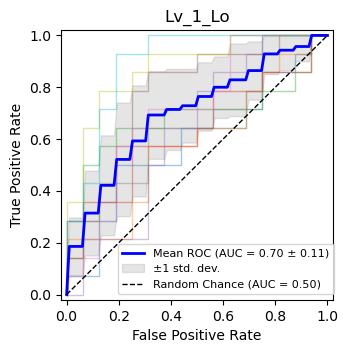

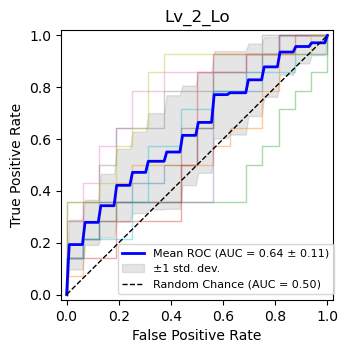

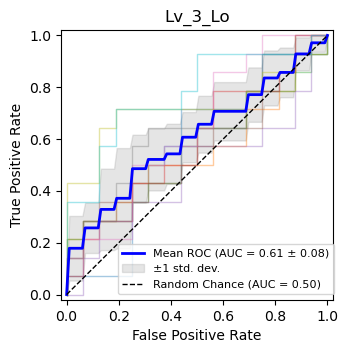

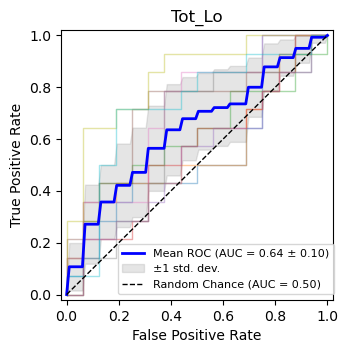

In [ ]:
for level in levels:
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    plt.figure(figsize = (3.5, 3.5))

    for fold_idx, prediction_probabilities in enumerate(weighted_average_probability_prediction_probabiltiies["Actual"][level]):
        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(out_tests[i], prediction_probabilities)
        roc_auc = auc(fpr, tpr)

        # Interpolate to standardize the TPR values
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0

        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        # Plot ROC curve
        plt.plot(fpr, tpr, lw = 1, alpha = 0.4)

    mean_tpr = np.mean(tprs, axis = 0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis = 0)

    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    # PLot mean ROC curve
    plt.plot(mean_fpr, mean_tpr, color = "b", lw = 2, alpha = 1, label = f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})")

    # Plot standard deviation area
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color = "grey", alpha = 0.2, label = "±1 std. dev.")

    # Plot diagonal "chance" line
    plt.plot([0, 1], [0, 1], color = "k", linestyle = "--", lw = 1, label = "Random Chance (AUC = 0.50)")

    # Final formatting
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(level)
    
    plt.legend(loc = "lower right", bbox_to_anchor = (1.025, 0.0), fontsize = 8)
    plt.show()